In [1]:
#imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))


In [2]:
#reading csv
df = pd.read_csv('NSE-TATAGLOBAL.csv')

In [3]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [4]:
pd.isnull(df).sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [5]:
#data-preprocessing
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

In [6]:
#auto ARIMA
from pmdarima.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = data[:987]
valid = data[987:]

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=248)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=6.45 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5477.259, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5168.276, Time=0.57 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.69 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5479.164, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5076.280, Time=1.39 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=9.40 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.93 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5074.398, Time=0.92 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5166.277, Time=0.34 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=5.47 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.69 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5076.285, Time=1.68 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5077.935, Time=3.23 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=5076.3

In [7]:
#calculating rsme of auto arima model
rmse=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rmse

54.54322879072438

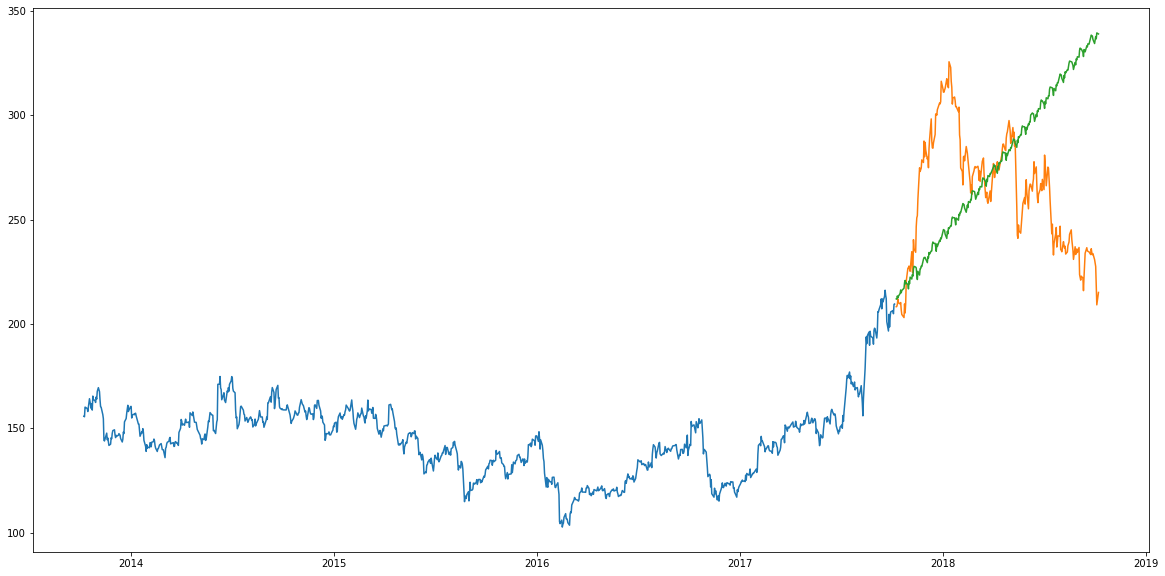

In [8]:
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

In [9]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
    
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [10]:
#LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

927/927 - 32s - loss: 0.0011


In [11]:
#rsme of lstm model
rmse=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rmse

10.16919223138239

C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


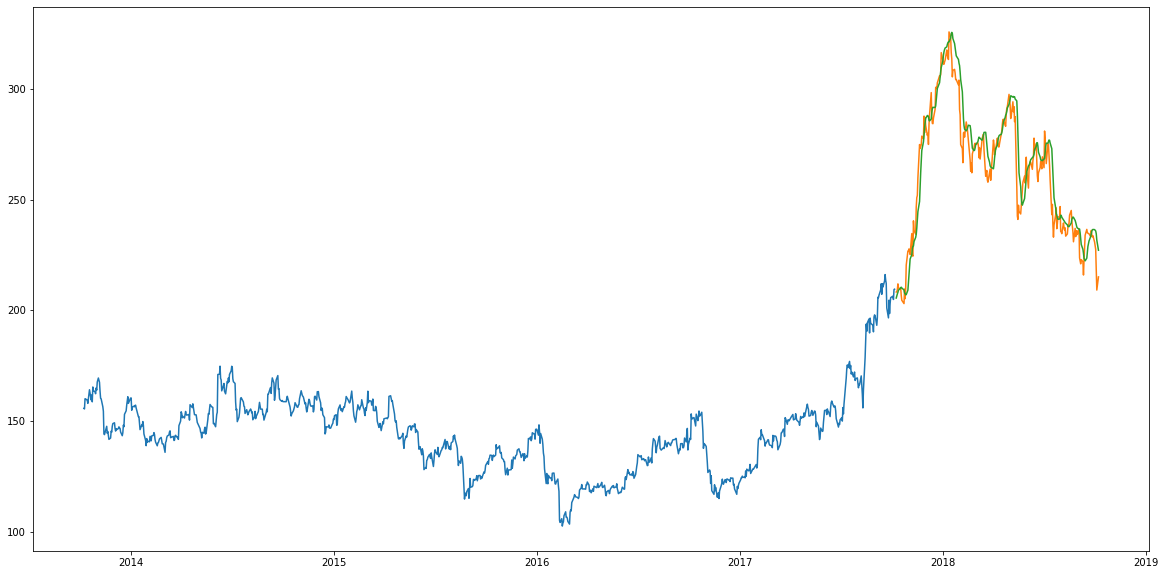

In [13]:
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])